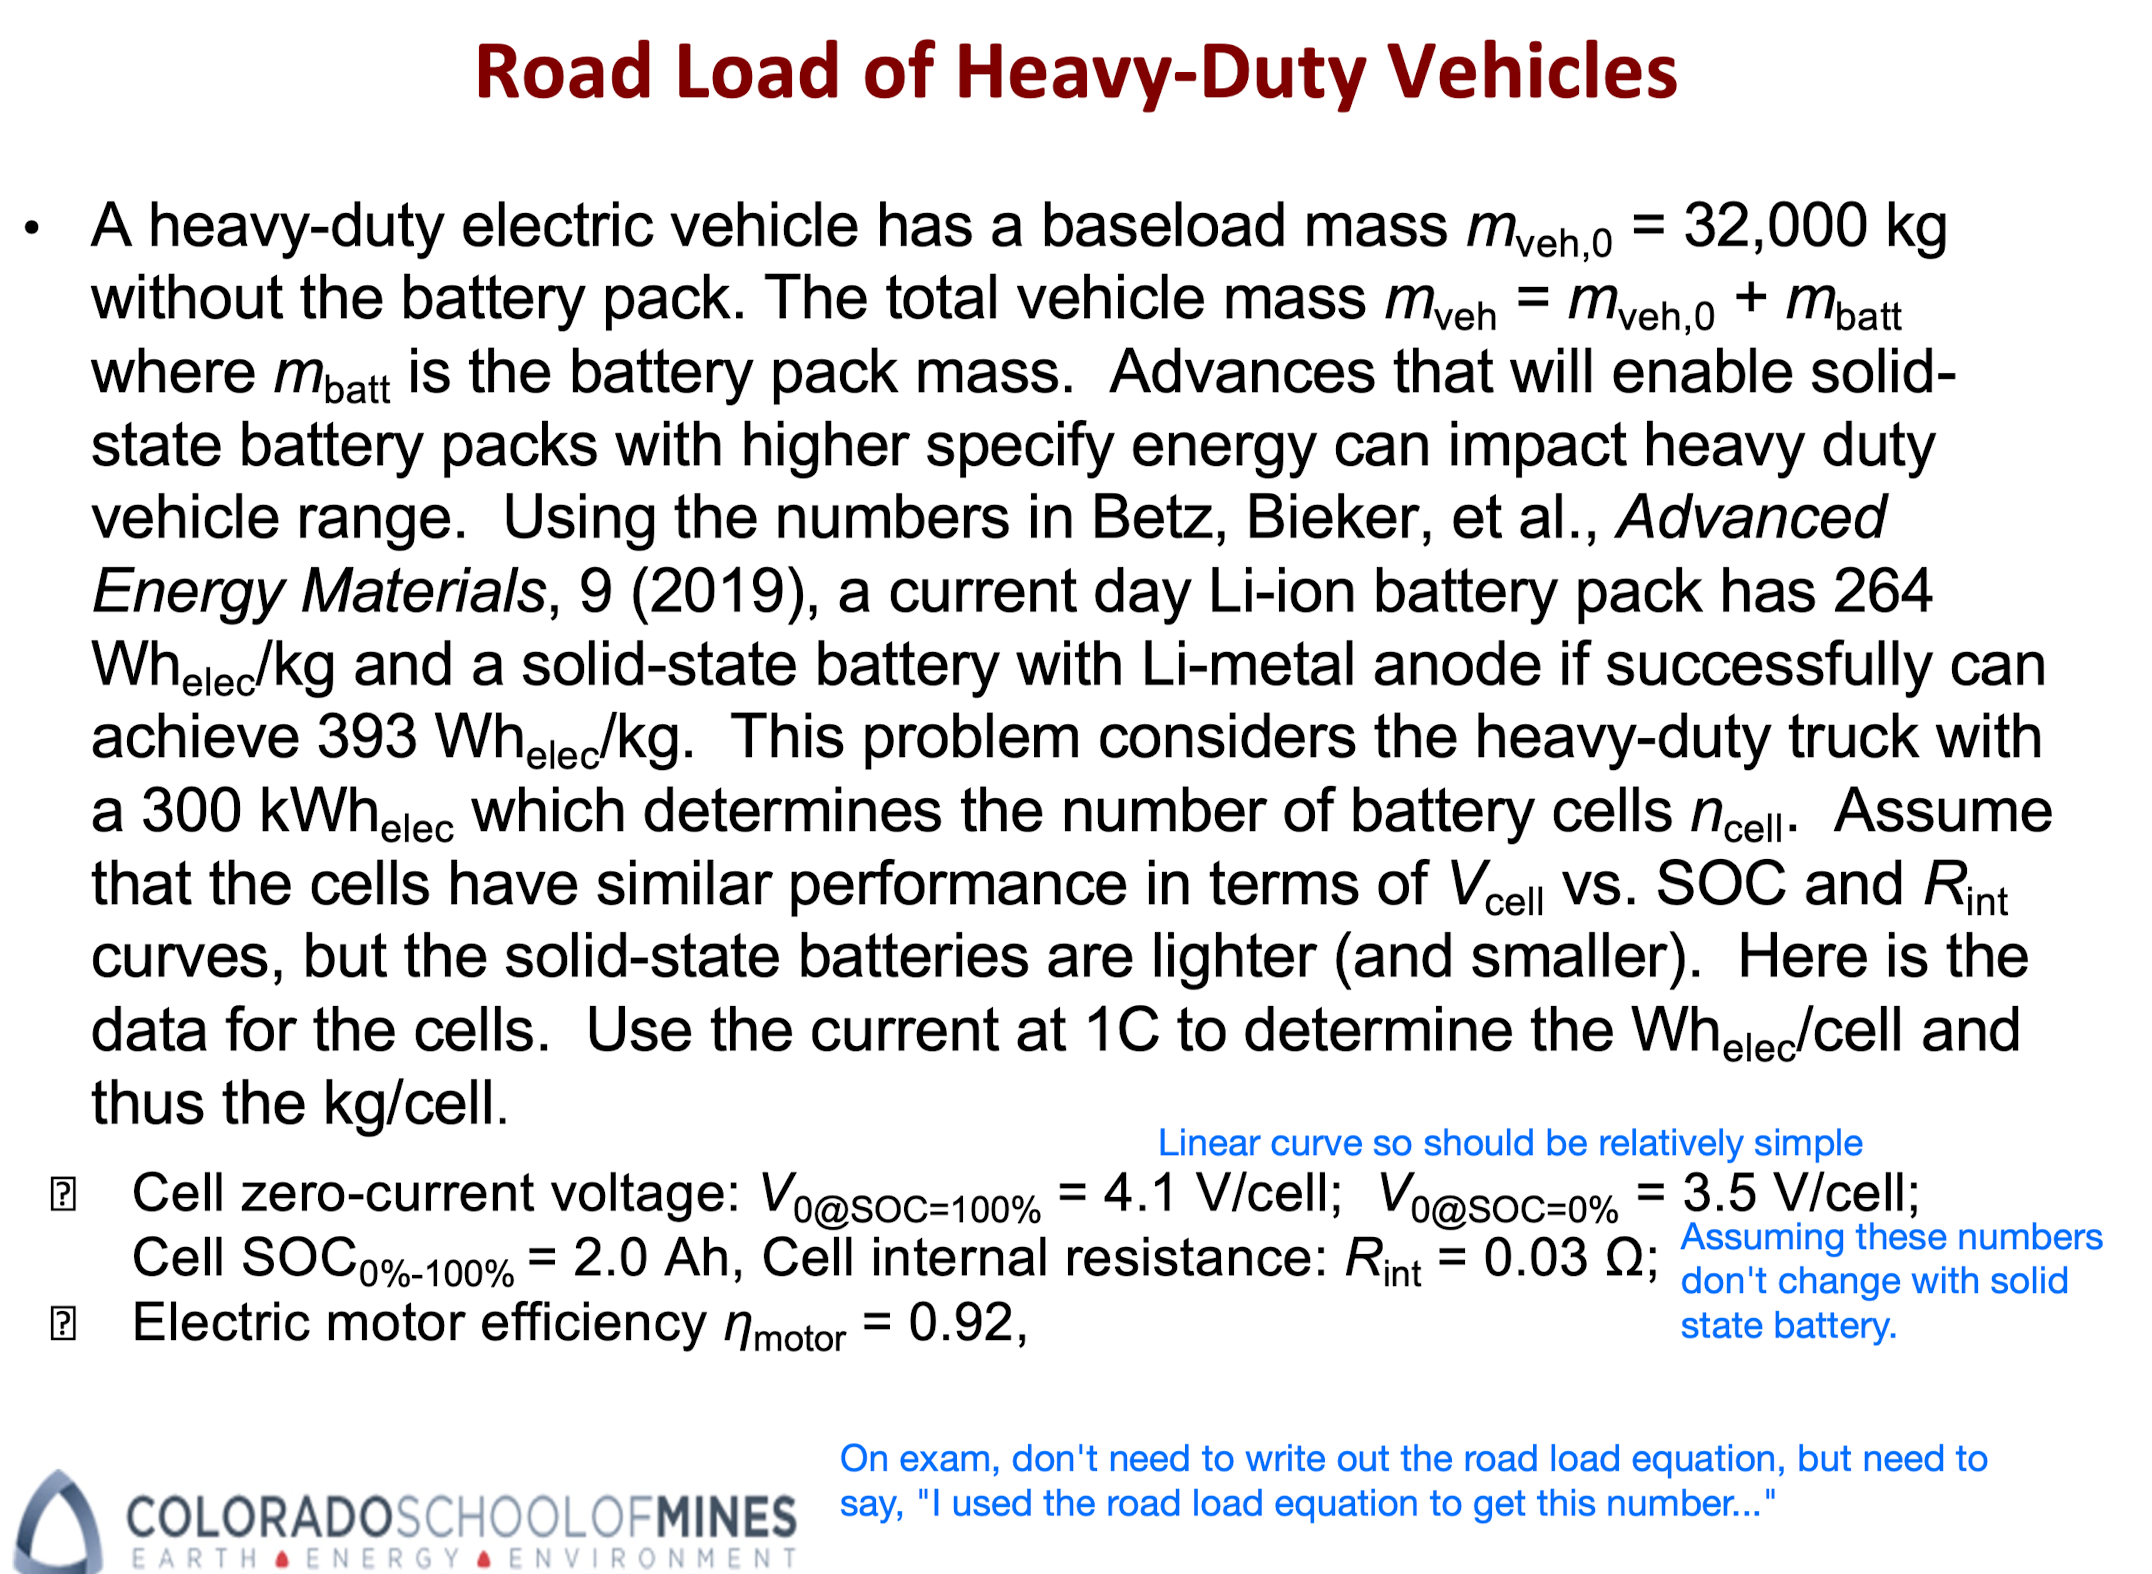
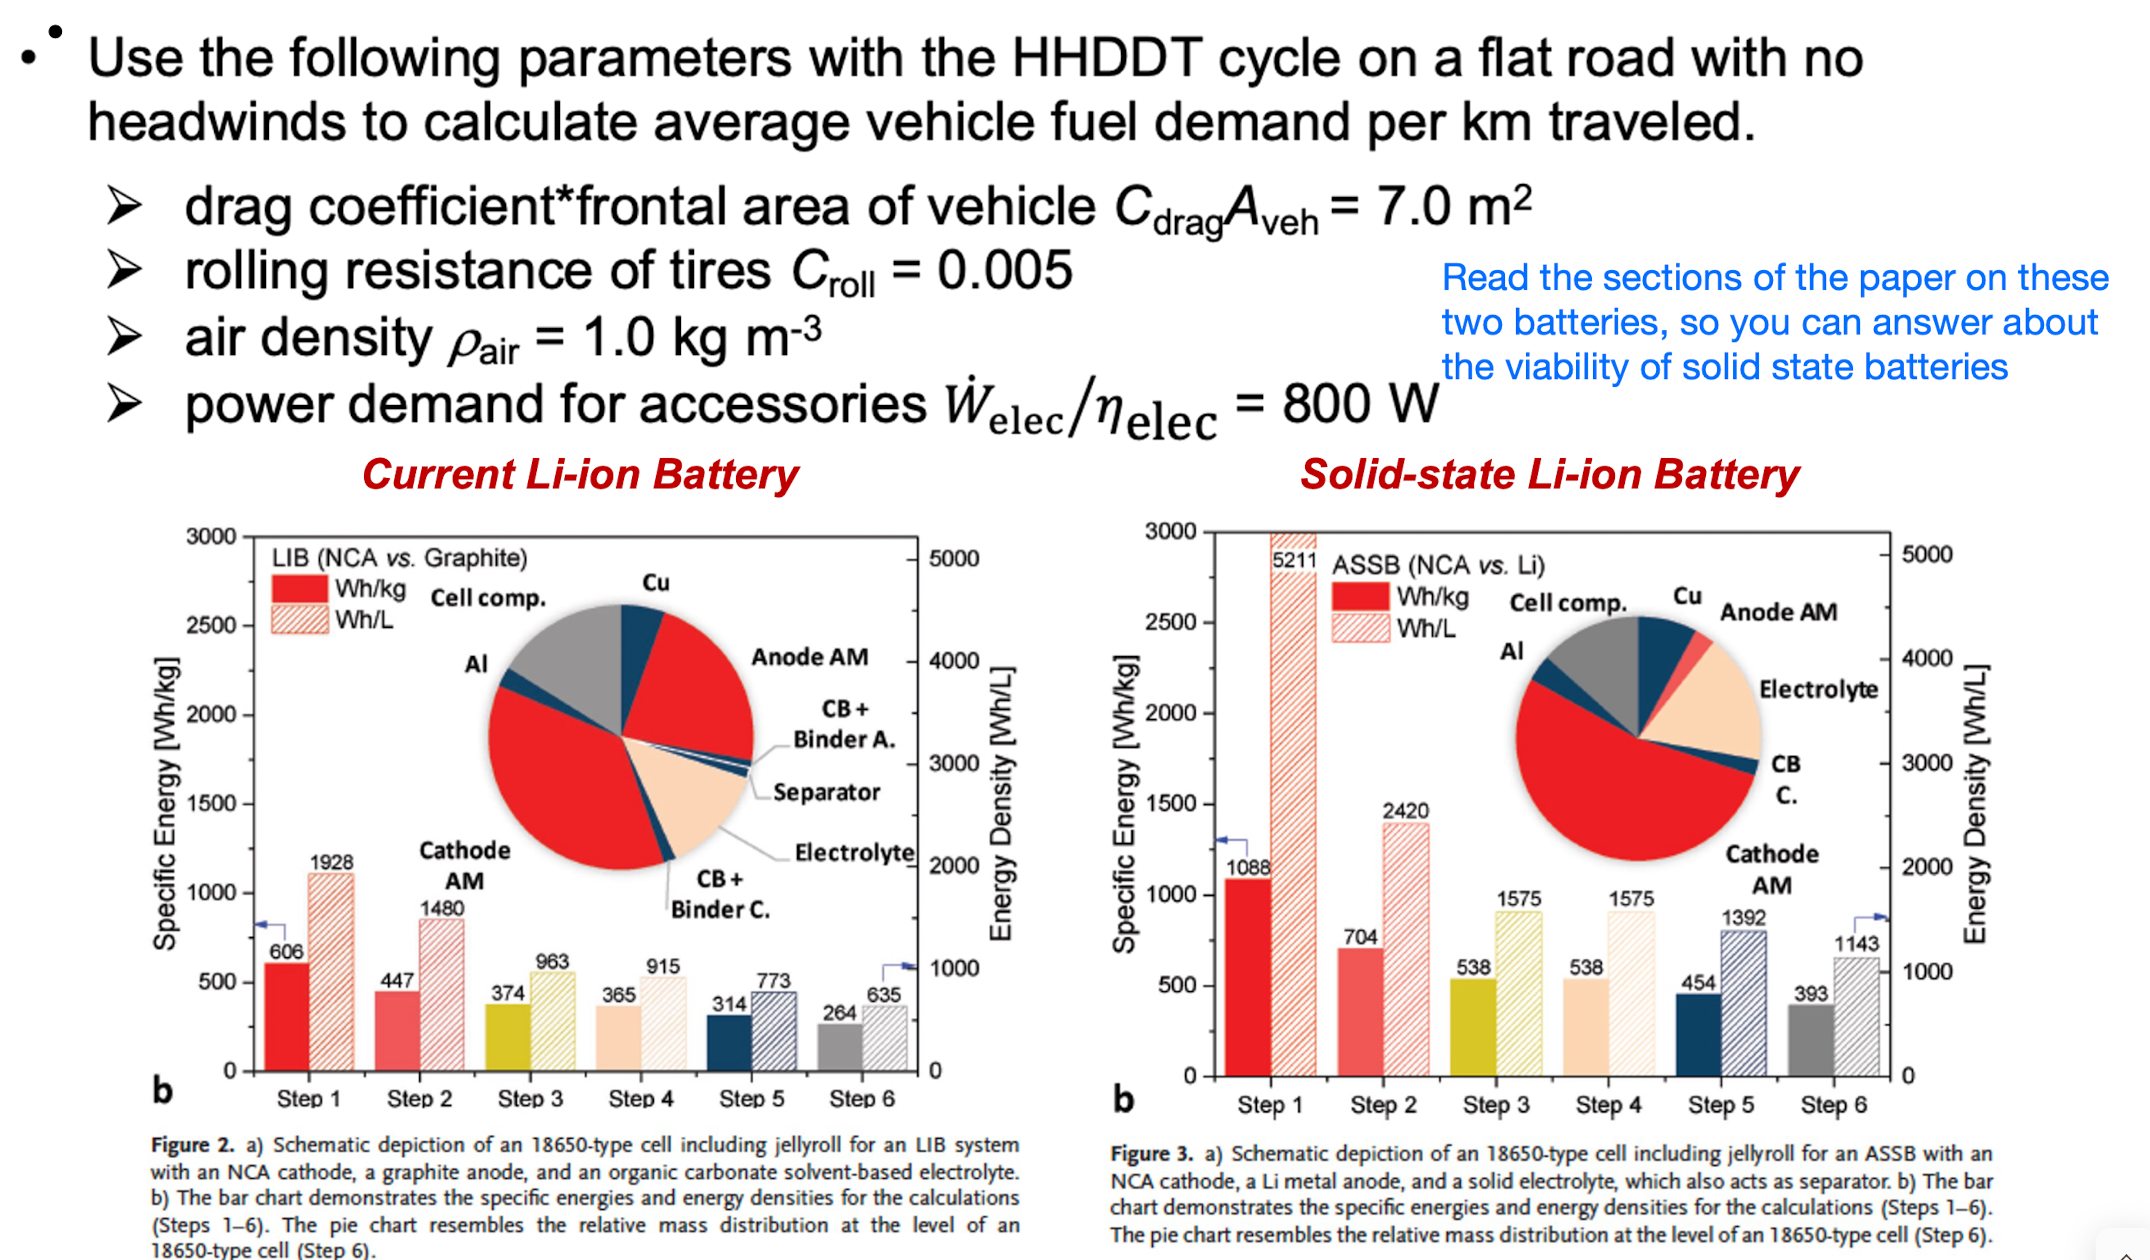

Time (s)  Speed (kph)
0            1          0.0
1            2          0.0
2            3          0.0
3            4          0.0
4            5          0.0
...        ...          ...
2078      2079          0.0
2079      2080          0.0
2080      2081          0.0
2081      2082          0.0
2082      2083          0.0

[2083 rows x 2 columns]

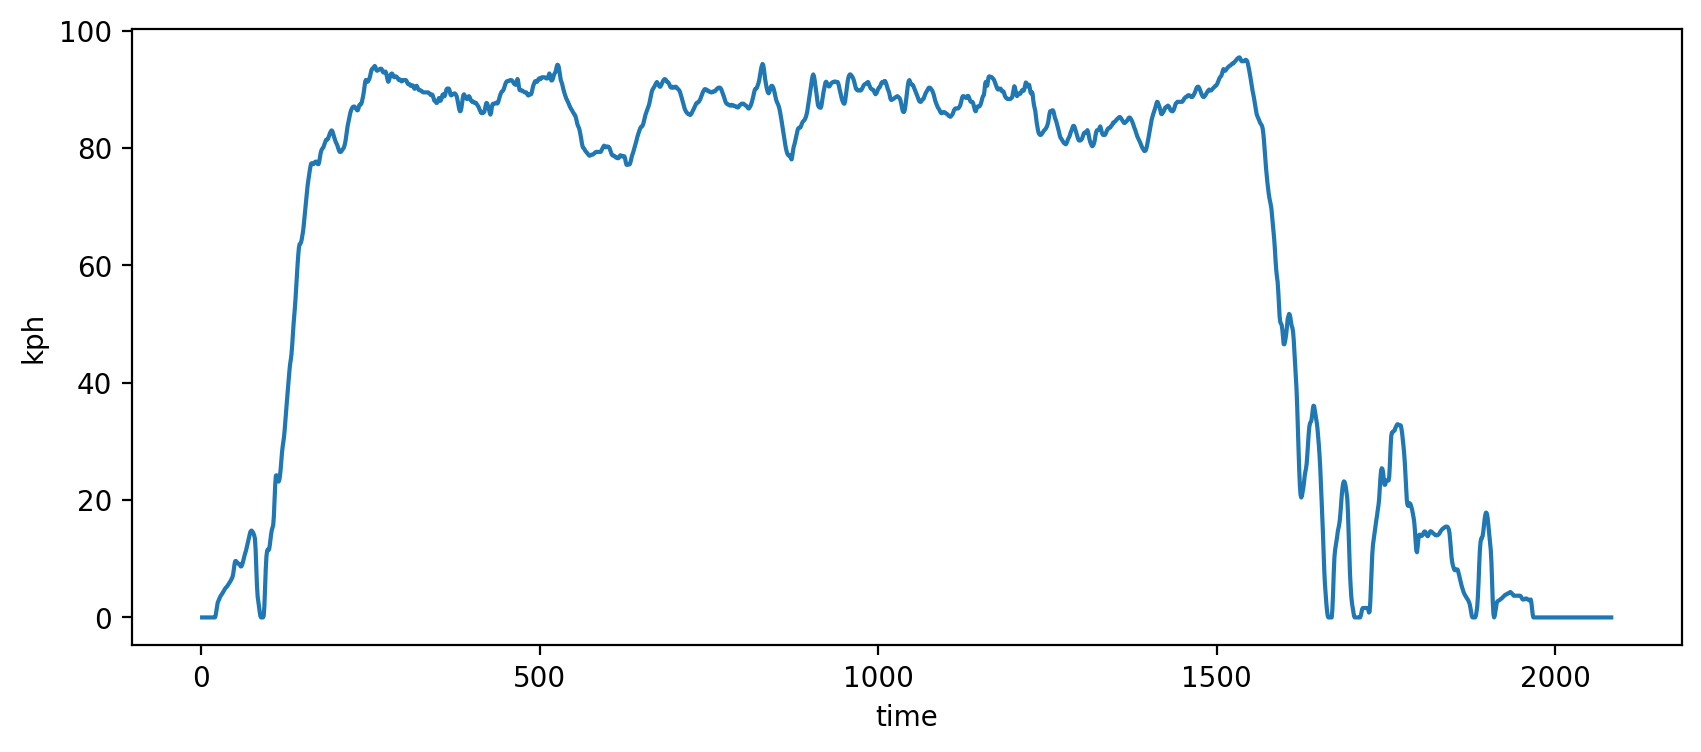

In [17]:
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np


df_hhddt = pd.read_csv("./HHDDT_cruise.csv")

km_per_mile = 1.60934
df_hhddt.iloc[:, 1] = df_hhddt.iloc[:, 1].map(lambda x: x * km_per_mile)
df_hhddt = df_hhddt.rename(columns={"Speed (mph)": "Speed (kph)"})

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_hhddt.iloc[:, 0], df_hhddt.iloc[:, 1])
ax.set_ylabel("kph")
ax.set_xlabel("time")

df_hhddt

In [89]:
kph_to_mps = 0.277778  # 1 kph = 0.277778 m/s
G = 9.81  # m/s^2
energydensity_fuel = 34.2  # gasoline energy density (in MJ/l)

# ambient air conditions
ambient = dict(
    v_air=0,  # ambient wind velocity where negative is headwind  (in m/s)
    # temp=25 + 273.15,  # ambient air temperature (in K)
    # pressure=98000,  # ambient air pressure (in Pa)
    rho=1.0,  # hardcoding in air density kg/m^3
)
alpha = 0  # flat road


cycle = dict(
    time=[df_hhddt["Time (s)"].values],
    mps=[
        df_hhddt["Speed (kph)"].values * kph_to_mps,
    ],
    name=["HHDDT cruise"],
)


# Function to solve system of 1st-order linear ODEs with oscillatory forcing
def dydt_vehicle(
    t, y, cycle, vehicle, amb, index
):  # Determine instantaneous values of velocity, acceleration, and road angle.
    dydt = [0] * len(y)

    v_veh = np.interp(t, cycle["time"][0], cycle["v_veh"])
    dv_vehdt = np.interp(t, cycle["time"][0], cycle["dv_vehdt"])

    # Set instantaneous velocity
    dydt[index["x"]] = v_veh

    C_roll = vehicle["C_roll_0"]

    term = (
        vehicle["mass"] * (dv_vehdt + G * np.sin(alpha) + C_roll * G * np.cos(alpha))
        + vehicle["C_drag"]
        * vehicle["A_front"]
        * 0.5
        * amb["rho"]
        * (v_veh - amb["v_air"]) ** 2
    )
    Wdot_veh = (max(0, term)) * v_veh + vehicle["Wdot_access"] / vehicle["eta_elec"]

    dydt[index["E_veh"]] = Wdot_veh

    # Determine power train efficiency and instantaneous fuel energy demand rate
    # eta = vehicle["eta_pt"](Wdot_veh / 1000)
    eta=vehicle["eta_elec"] * vehicle["eta_motor"]
    dydt[index["E_fuel"]] = Wdot_veh / eta
    return dydt


# Set up indices and intial conditions for solution vector y(t) = [x; Wdot_veh]'
index = dict(x=0, E_veh=1, E_fuel=2)
y_0 = [None] * 3
y_0[index["x"]] = 0
y_0[index["E_veh"]] = 0
y_0[index["E_fuel"]] = 0


def calculate_loads(vehicle):
    for idx, speed in enumerate(cycle["mps"]):
        time = cycle["time"][idx]
        print(time)
        arr_length = len(time)

        #  driving cycle vehicle velocities [m/s]
        cycle["v_veh"] = speed
        # road angle to horizontal  [deg.]
        cycle["alpha"] = [0] * arr_length
        # Calculate vehicle acceleration and identify times when acceleration is positive, zero for this problem
        cycle["dv_vehdt"] = np.gradient(cycle["v_veh"])

        # Call an ODE integrator to solve for y(t)
        sol = solve_ivp(
            dydt_vehicle,
            [0, time[-1] + 1],
            y_0,
            "RK45",
            time,
            args=(cycle, vehicle, ambient, index),
            rtol=1e-4,
            atol=1e-4,
        )

        vehicle["x"][idx] = sol.y[index["x"]] / 1000
        vehicle["E_veh"][idx] = sol.y[index["E_veh"]] / 1000
        vehicle["E_fuel"][idx] = sol.y[index["E_fuel"]] / 1000
        vehicle["kmperliter"][idx] = [0] * arr_length
        vehicle["kmperliter"][idx] = (
            1000
            * vehicle["x"][idx]
            / (
                vehicle["E_fuel"][idx] / energydensity_fuel
            )  # don't use this, not using a gasoline vehicle
        )
        vehicle["mpg"][idx] = 2.35215 * vehicle["kmperliter"][idx]

        #  Allocate memory for vectors for calculating vehicle power requirements
        vehicle["Wdot_drag"][idx] = np.zeros(arr_length)
        vehicle["Wdot_roll"][idx] = np.zeros(arr_length)
        vehicle["Wdot_accel"][idx] = np.zeros(arr_length)

        # Calculate instantaneous power (in kW) to overcome forces on vehicle
        #   and integrate to get total work required (in kWh)
        vehicle["Wdot_drag"][idx] = (
            (
                np.array(
                    vehicle["C_drag"]
                    * vehicle["A_front"]
                    * 0.5
                    * ambient["rho"]
                    * (np.array(cycle["v_veh"]) - ambient["v_air"]) ** 2
                )
            )
            * cycle["v_veh"]
            / 1000
        )

        C_roll = vehicle["C_roll_0"]
        vehicle["Wdot_roll"][idx] = (
            vehicle["mass"]
            * C_roll
            * (G * np.cos(cycle["alpha"]) * cycle["v_veh"] / 1000)
        )
        vehicle["Wdot_accel"][idx] = vehicle["mass"] * (
            np.array([max(0, dv_dt) for dv_dt in cycle["dv_vehdt"]])
            * cycle["v_veh"]
            / 1000
        )
        vehicle["Wdot_access_vec"][idx] = (
            np.ones(arr_length) * vehicle["Wdot_access"] / vehicle["eta_elec"] / 1000
        )
        vehicle["Wdot"][idx] = (
            vehicle["Wdot_drag"][idx]
            + vehicle["Wdot_roll"][idx]
            + vehicle["Wdot_accel"][idx]
            + vehicle["Wdot_access_vec"][idx]
        )

    return vehicle

[   1    2    3 ... 2081 2082 2083]
37.062661592016354


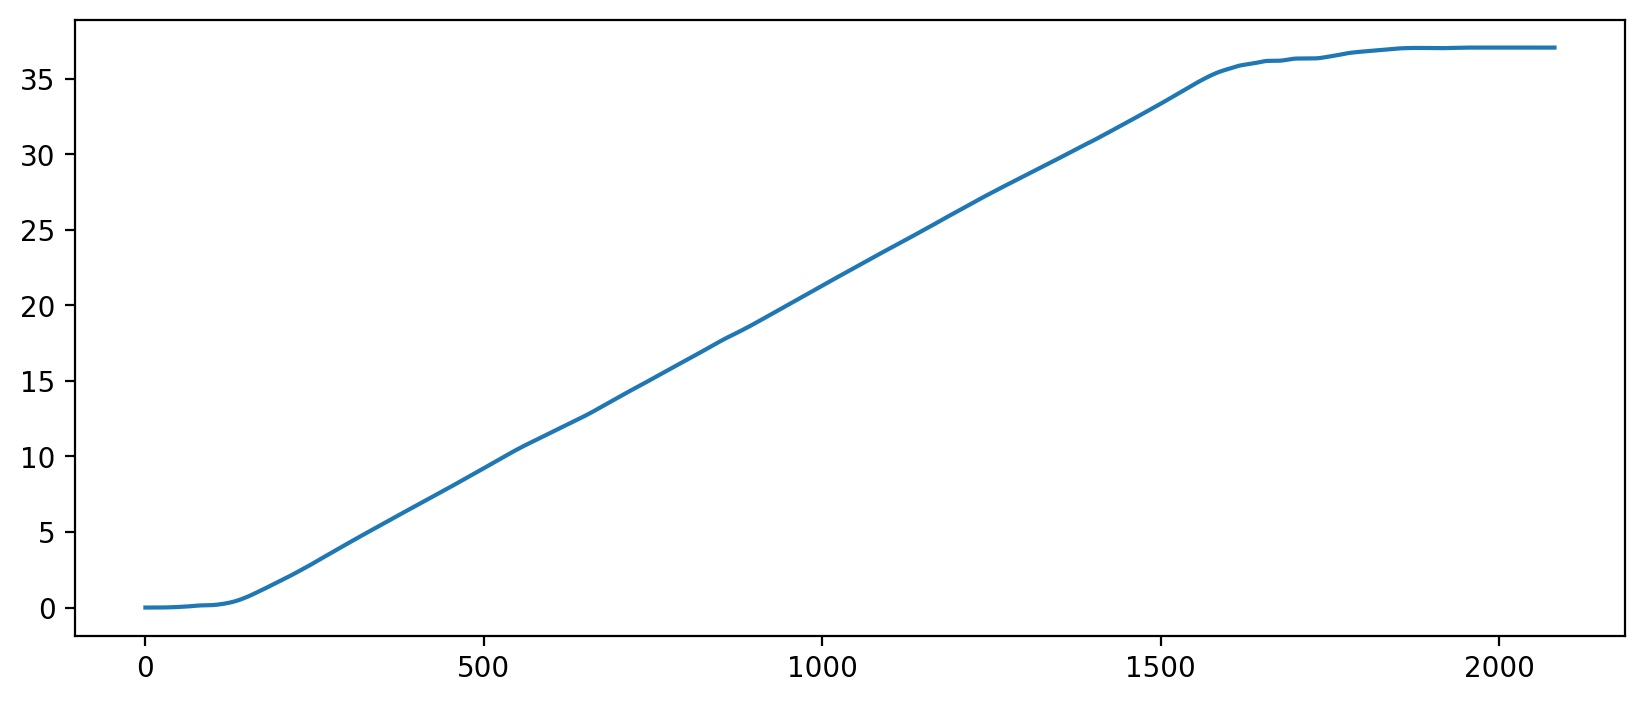

In [92]:
eta_elec = 0.95
cycle_len = len(df_hhddt["Time (s)"])

mass_base = 32_000
# mass_battery = 1136.4 # current Li-ion
mass_battery = 763.36 # solid state
vehicle_truck_bev = dict(
    C_drag=0.7,  # drag coefficient [-]
    A_front=10,  # frontal area for drag [m^2]
    C_roll_0=0.005,  # tire rolling resistance coefficient [-]
    Wdot_access=760,  # average accessory loads [W]
    # To be filled in later
    Wdot_drag=[0] * cycle_len,
    Wdot_roll=[0] * cycle_len,
    Wdot_accel=[0] * cycle_len,
    Wdot_access_vec=[0] * cycle_len,
    Wdot=[0] * cycle_len,
    x=[0] * cycle_len,
    E_veh=[0] * cycle_len,
    E_fuel=[0] * cycle_len,
    kmperliter=[0] * cycle_len,
    mpg=[0] * cycle_len,
    mass=mass_base + mass_battery,
    eta_elec=eta_elec,
    eta_motor = 0.92,
)
vehicle_truck_bev = calculate_loads(vehicle_truck_bev)

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(vehicle_truck_bev["x"][0])

distance_travelled = max(vehicle_truck_bev["x"][0]) # km
print(distance_travelled)

7.56888722786795
1.2550984465438073


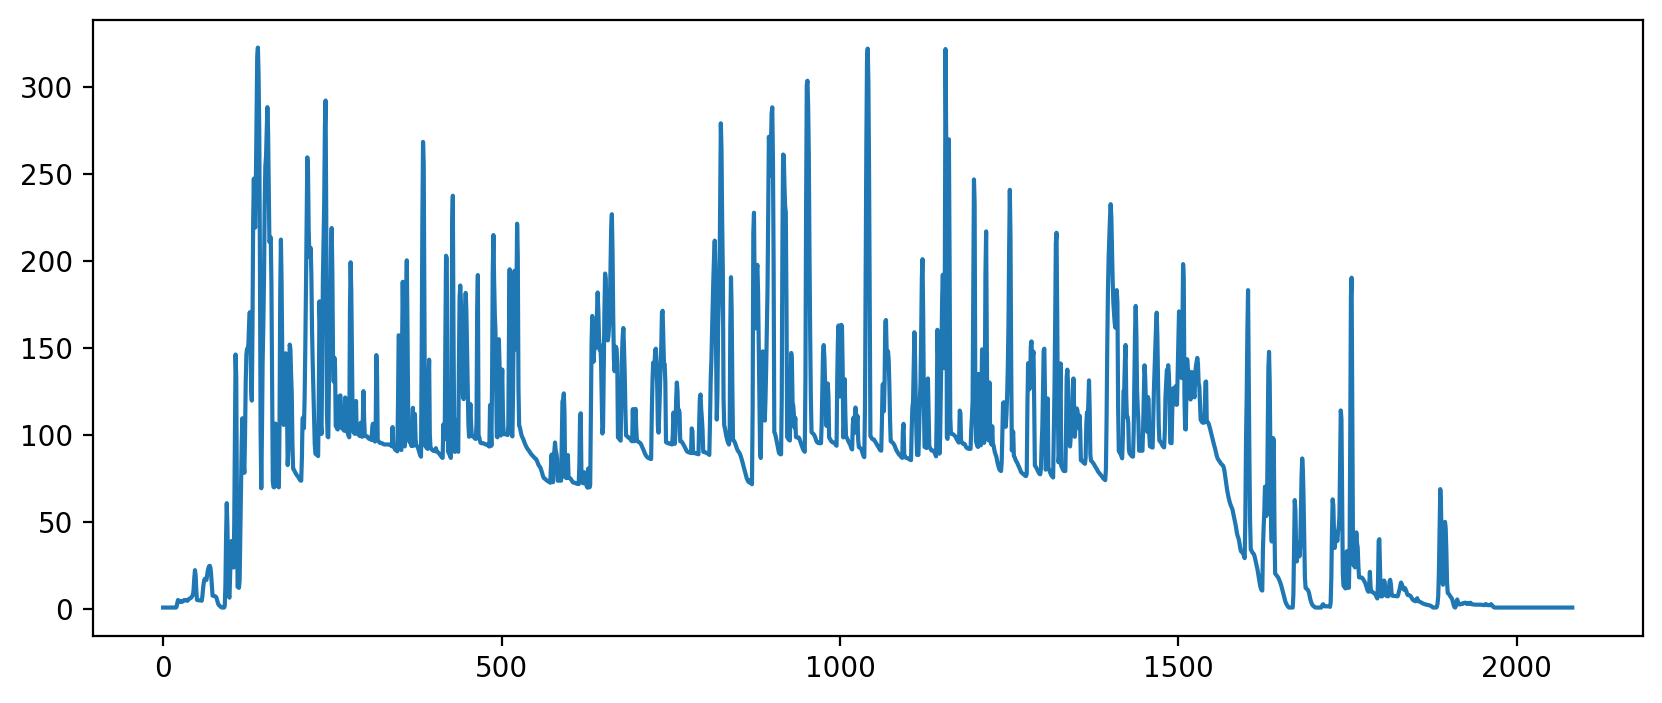

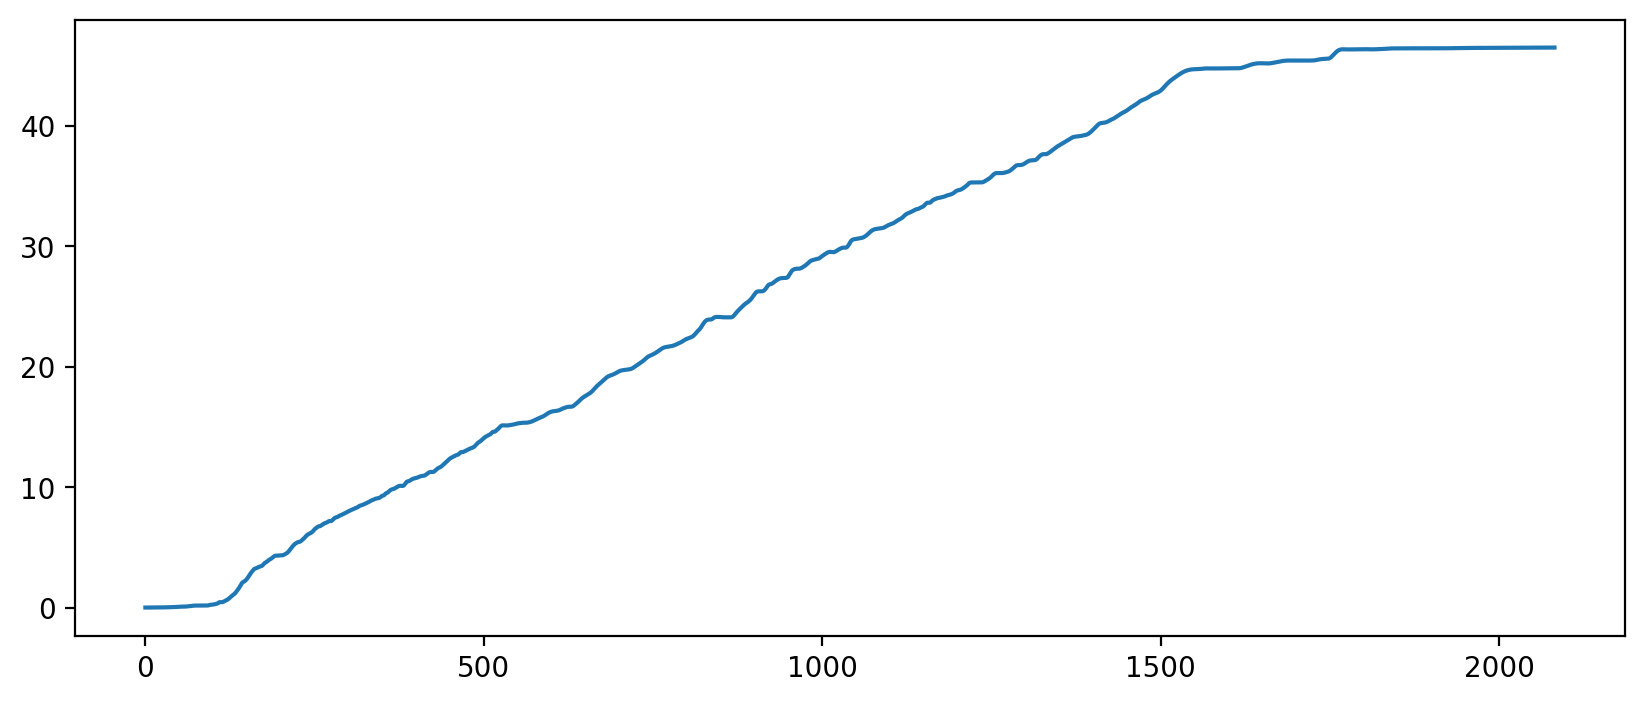

In [93]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(vehicle_truck_bev["Wdot"][0])

# ax.plot(vehicle_truck_bev["E_fuel"][0])

fuel_economy = distance_travelled / max(vehicle_truck_bev["E_fuel"][0])

print((vehicle_truck_bev["kmperliter"][0][-1]))

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(vehicle_truck_bev["E_fuel"][0] / 3600)

energy_used = max(vehicle_truck_bev["E_fuel"][0] / 3600)  # kWh

fuel_per_km = energy_used / distance_travelled
print(fuel_per_km)